In [12]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import homebrew as hb
%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open('/Users/patrickfuller/.secrets/spotify_api.json') as f:
    creds = json.load(f)
client_id = creds['client_id']
key = creds['api_key']

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id,
                                                      client_secret=key)

spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [9]:
cat_list = []
response = spotify.categories(country='US', limit=50)
items = response['categories']['items']
for item in items:
    category = item['id']
    cat_list.append(category)

In [10]:
for cat in ['family', 'comedy', 'word', 'ellen', 'sleep']:   
    cat_list.remove(cat)

In [12]:
master_playlist_dict = {}
for category in cat_list:
    offset = 0
    while True:
        response = spotify.category_playlists(category_id=category,
                                                             offset=offset,
                                                             limit=50, country='US',
                                                             )
        current_names_ids = hb.extract_name_and_id(response)
        if current_names_ids == {}:                     # If we run out of playlists in a category
            break                                       # we move on to the next category
        master_playlist_dict.update(current_names_ids)
        offset += 50

In [25]:
# with open('playlists_artists_redundant.json', 'w') as f:
#     for pl_id, pl_data in list(master_playlist_dict.items()):
#         pl_artists = []
#         offset = 0
#         for _ in range(2):
#             try:
#                 response = spotify.user_playlist_tracks(user=pl_data['owner_id'],
#                                              playlist_id=pl_id,
#                                              limit=100)
#                 current_artists = hb.get_artists_in_playlist(response)
#                 pl_artists.extend(current_artists)
#                 unique = set(pl_artists)
#                 for artist in unique:
#                     line = {
#                         'artist':(artist),
#                         'playlist':(pl_data['name'], pl_id),
#                     }
#                     json.dump(line, f)
#                     f.write('\n')
#             except:
#                 pass

# # Commented out to prevent re-writing the file. Doesn't take for ever but non-negligeable

In [3]:
df = pd.read_json('playlists_artists_redundant.json', lines=True)

In [4]:
display(df.shape)
df.head()

(218706, 2)

,artist,playlist
0,DJ Snake,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
1,TINI,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
2,Bon Iver,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
3,Jon Z,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
4,Martin Garrix,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"


In [5]:
len(df.artist.unique())

43786

In [6]:
df.artist.value_counts()[:50]  # These artists are showing up in the most playlists

J Balvin                     248
Bad Bunny                    214
Drake                        202
Cardi B                      186
Daddy Yankee                 182
Farruko                      180
Nicky Jam                    178
Ozuna                        176
Maluma                       174
Khalid                       172
Ed Sheeran                   170
Nicki Minaj                  165
Camila Cabello               150
Justin Bieber                146
Marshmello                   146
Diplo                        144
Beyoncé                      143
Ty Dolla $ign                138
Anuel Aa                     136
Zion & Lennox                132
Shawn Mendes                 132
Wisin                        128
Rihanna                      128
Natti Natasha                124
Post Malone                  122
Mark Ronson                  122
Taylor Swift                 122
French Montana               118
Maren Morris                 118
Tyga                         117
Katy Perry

Text(0.5, 1.0, 'Artist Appearance in Playlists')

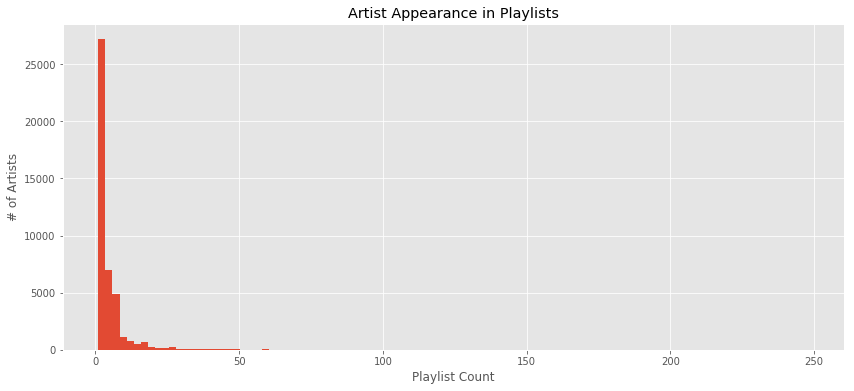

In [24]:
plt.figure(figsize=(14,6))
df.artist.value_counts().hist(bins=100)
plt.xlabel('Playlist Count')
plt.ylabel('# of Artists')
plt.title('Artist Appearance in Playlists')

We won't be able to gain much information from artists only appearing in a few playlists.
Dropping them will reduce computational cost with little to no cost to predictive power.

In [54]:
top_artists_counts = [(v, c) for v, c in df.artist.value_counts().items() if c >= 10]
print(f'There are {len(top_artists_counts)} artists appearing in 10 or more playlists')
print('The top twenty are ...')
top_artists_counts[:20]

There are 4728 artists appearing in 10 or more playlists
The top twenty are ...


[('J Balvin', 248),
 ('Bad Bunny', 214),
 ('Drake', 202),
 ('Cardi B', 186),
 ('Daddy Yankee', 182),
 ('Farruko', 180),
 ('Nicky Jam', 178),
 ('Ozuna', 176),
 ('Maluma', 174),
 ('Khalid', 172),
 ('Ed Sheeran', 170),
 ('Nicki Minaj', 165),
 ('Camila Cabello', 150),
 ('Justin Bieber', 146),
 ('Marshmello', 146),
 ('Diplo', 144),
 ('Beyoncé', 143),
 ('Ty Dolla $ign', 138),
 ('Anuel Aa', 136),
 ('Zion & Lennox', 132)]

In [101]:
top_artists=[x[0] for x in top_artists_counts]
trimmed_df = df[df.artist.isin(top_artists)].copy()
trimmed_df.shape

(103720, 2)

In [102]:
trimmed_df.playlist = df.playlist.apply(lambda x: x[1]) # OneHot doesn't like lists or sets

In [103]:
trimmed_df.head()

,artist,playlist
0,DJ Snake,37i9dQZF1DXcBWIGoYBM5M
1,TINI,37i9dQZF1DXcBWIGoYBM5M
2,Bon Iver,37i9dQZF1DXcBWIGoYBM5M
3,Jon Z,37i9dQZF1DXcBWIGoYBM5M
4,Martin Garrix,37i9dQZF1DXcBWIGoYBM5M


In [104]:
encoder = OneHotEncoder(drop='first', categories='auto')
encoder.fit(trimmed_df[['playlist']])

ohe_playlists= pd.DataFrame(encoder.transform(trimmed_df[['playlist']]).toarray(),
                          columns=encoder.get_feature_names(['playlist']))

In [105]:
artists_ohe_playlists = pd.concat([trimmed_df.drop('playlist', axis=1),
                                   ohe_playlists],
                                   axis=1)

In [106]:
artists_ohe_playlists.shape

(151210, 1691)

In [107]:
artist_w_flagged_playlists = artists_ohe_playlists.groupby('artist').sum()

In [110]:
print(artist_w_flagged_playlists.shape)
artist_w_flagged_playlists.head(20)

(4728, 1690)


,playlist_08CJ6fWrTA1vMfwVwAxWUl,playlist_0Gy1TwCxPFTMCiwxGLVkc1,playlist_0T22esVKW7cTZEN7XzXV14,playlist_0YMVY3uhQNd7WUf0hSByrX,playlist_0ZWYUjUMhaq0Rammqq3qu1,playlist_0bx5Dgu5yOEhST49LP67su,playlist_0fmLn46c92nP4dePQSZlsz,playlist_0k7YwkrfJ2BsRMFBP5W5xK,playlist_0yfTPCk6Cnhm9wtoEaXXlo,playlist_13thjkLTYZmZvjdz4u6kxh,...,playlist_73gXbLcjix7p1pPsQClusE,playlist_7A2YimOfIrmAWkCeSIY8Rq,playlist_7EnyqmmhFgfhicejZiVV13,playlist_7EpJpnU6KrSc430F8B5tM7,playlist_7FDyC1JdV3jkGzAE9BONKt,playlist_7HQu1GUDVSx64GdCpaB88I,playlist_7JXJKP3xMvIMbEBBGApTPQ,playlist_7b9DiMN2kttG8lYQogfQBw,playlist_7fzFQUIVM4TumzRWo5UFP2,playlist_7kdOsNnHtzwncTBnI3J17w
artist,,,,,,,,,,,,,,,,,,,,,
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""CHEN",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$uicideBoy$,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&ME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(G)I-DLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(Sandy) Alex G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
*NSYNC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
015B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
070 Shake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
indexed_artists_and_flags = artist_w_flagged_playlists.reset_index()
indexed_artists_and_flags.head()

,artist,playlist_08CJ6fWrTA1vMfwVwAxWUl,playlist_0Gy1TwCxPFTMCiwxGLVkc1,playlist_0T22esVKW7cTZEN7XzXV14,playlist_0YMVY3uhQNd7WUf0hSByrX,playlist_0ZWYUjUMhaq0Rammqq3qu1,playlist_0bx5Dgu5yOEhST49LP67su,playlist_0fmLn46c92nP4dePQSZlsz,playlist_0k7YwkrfJ2BsRMFBP5W5xK,playlist_0yfTPCk6Cnhm9wtoEaXXlo,...,playlist_73gXbLcjix7p1pPsQClusE,playlist_7A2YimOfIrmAWkCeSIY8Rq,playlist_7EnyqmmhFgfhicejZiVV13,playlist_7EpJpnU6KrSc430F8B5tM7,playlist_7FDyC1JdV3jkGzAE9BONKt,playlist_7HQu1GUDVSx64GdCpaB88I,playlist_7JXJKP3xMvIMbEBBGApTPQ,playlist_7b9DiMN2kttG8lYQogfQBw,playlist_7fzFQUIVM4TumzRWo5UFP2,playlist_7kdOsNnHtzwncTBnI3J17w
0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""CHEN",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,$uicideBoy$,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,&ME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,(G)I-DLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
from sklearn.neighbors import NearestNeighbors

In [122]:
X = indexed_artists_and_flags.drop('artist', axis=1)

In [123]:
neighbors = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)

In [124]:
neighbors.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [125]:
distances, indices = neighbors.kneighbors(X)

In [128]:
distances[0]

array([2.22044605e-16, 5.83333333e-01, 6.22035527e-01, 6.25000000e-01,
       7.11324865e-01])

In [129]:
indices[0]

array([   0, 3159, 3533,  633, 1204])